코드 생성

In [384]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [385]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [386]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [387]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        

cor_data = []
for value in data:
    cor_data.extend([value] * 20)


Signal 생성

In [388]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        t = np.arange(1023 * OV * 20 * bits)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       

Replica 신호 생성

In [389]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, ts):
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        
        t = np.arange(1023 * OV * ts, 1023 * OV * ts + 1023 * OV)
        self.delayed_code = np.roll(ca_code, code_delay)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

Acquisition

In [390]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        # replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber, 1023 * OV, OV)
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 0)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
        
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
    # 20ms 안에서 bit boundary(B) 값 탐색
    cor_lst = []
    for i in range(ms):
        True_replica = Replica(max_code_delay, max_doppler_freq, code_freq, svNumber, 1023 * OV, OV, i)
        cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
        cor_lst.append(np.max(cor))  
    phase_diff = []
    for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
  
    return max_code_delay, max_doppler_freq, cor_lst, corr_matrix, dop_freq_max
    

Acquisition 실행

In [391]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20* 1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)

true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
# true_doppler_freq = -2750


received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
print("B :", true_code_delay//(OV*1023))
B = true_code_delay//(OV*1023)
print()
for i in range(-10,11):
    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 122.0
Estimated_Frequency Offset : -500.0
Max correlation : 1056.859265895196
----------------------------------------

------------------ Test ------------------
Target SV Number: 34
True Code Delay: 1144.9
True doppler frequency: -275
----------------------------------------
B : 1

-5000Hz : 122.01888891599671
-4500Hz : 126.40269161098465
-4000Hz : 143.20527345825906
-3500Hz : 134.47251081939737
-3000Hz : 132.01701170881438
-2500Hz : 140.54282483985207
-2000Hz : 130.06669481035752
-1500Hz : 146.74177430149635
-1000Hz : 411.5295900847001
-500Hz : 1056.859265895196
0Hz : 1006.2079089055417
500Hz : 308.11156178837314
1000Hz : 209.3187043622492
1500Hz : 146.27909988358903
2000Hz : 146.63766605907148
2500Hz : 128.88620795822894
3000Hz : 131.31745235849422
3500Hz : 124.69904149662841
4000Hz : 120.8308088746626
4500Hz : 128.33087410311435
5000Hz : 137.48497568413487


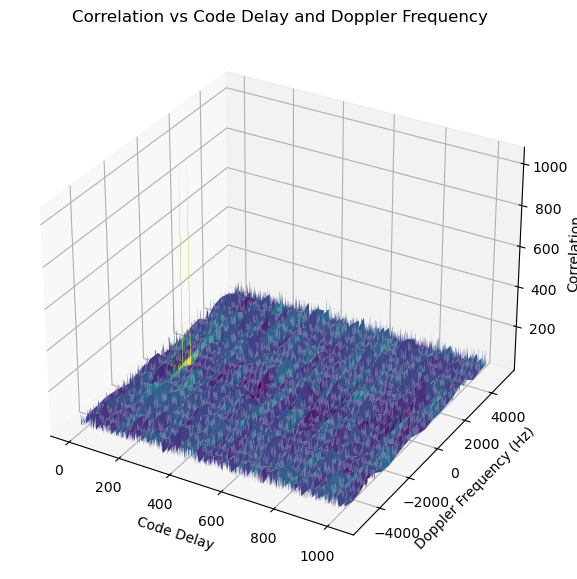

In [392]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



In [393]:
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 

degree_list = [np.degrees(value) for value in phase_diff]

Index 0: -83.95861940177045
Index 1: -80.54987138173054
Index 2: -78.4013353798068
Index 3: -83.05750160469597
Index 4: -81.96462368096648
Index 5: -79.97416798511927
Index 6: -80.22325624232168
Index 7: -79.62870784149473
Index 8: -81.31736219314836
Index 9: -81.23669556549706
Index 10: -82.23434359492427
Index 11: -79.23414304645922
Index 12: -83.06801539819232
Index 13: -81.08989028509862
Index 14: -80.09804034960293
Index 15: -81.1122390480773
Index 16: -80.77660335431263
Index 17: -84.40685649605096
Index 18: -78.11688184273596
Index 19: -80.24549726891384
Index 20: 87.39937683782847
Index 21: -71.79604808759767
Index 22: -78.49239169624047
Index 23: -81.40659861844655
Index 24: -81.55803599490879
Index 25: -83.81799916261596
Index 26: -77.75223196668794
Index 27: -83.37027523997844
Index 28: -79.6386666939582
Index 29: -78.55563765360628
Index 30: -86.01394610534635
Index 31: -76.37398198173594
Index 32: -82.09071550618667
Index 33: -80.55888722139586
Index 34: -82.02404010824863

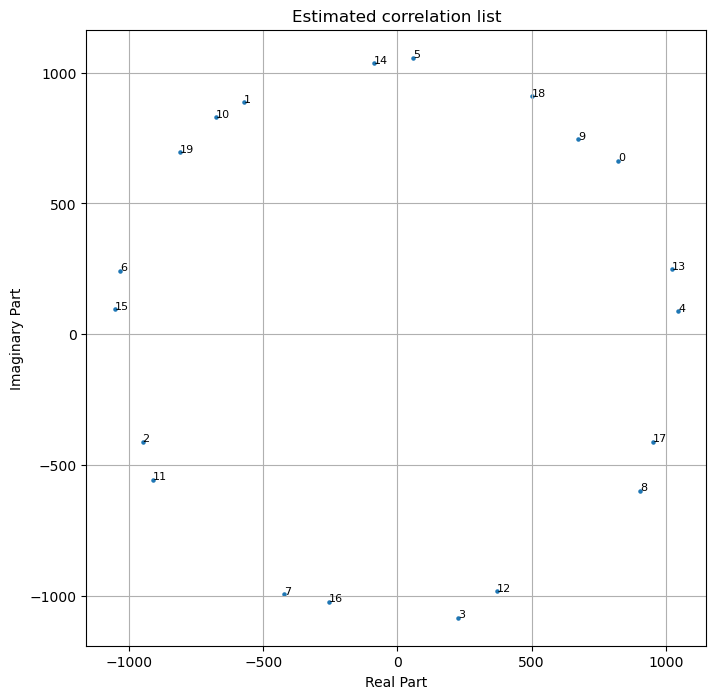

In [394]:

for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")



plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:20]), np.imag(cor_lst[:20]), s=5)

for i, txt in enumerate(range(0, 0 + 20)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [395]:
def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [25, 75])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers


data = degree_list

outliers = find_outliers(data)
print("이상치:", outliers)


if len(outliers)>=1:
    tmp = outliers[1]
    print("첫번째 이상치", tmp)
    idx = degree_list.index(tmp)

    outlier_index = idx
    print("원래", outlier_index)

    if outlier_index>=20:
        outlier_index = outlier_index-20
        
    print("estimated B", outlier_index)
    print("B", B)
elif len(outliers) == 0:
    print("B = 0")
    


print()


def find_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = [(i + 20, x) for i, x in enumerate(data) if abs((x - mean) / std) > threshold]
    return outliers

data = degree_list[20:40]
outliers_z = find_outliers_z_score(data)
print("참고: 이상치 (Z-Score):", outliers_z)

이상치: [87.39937683782847, -71.79604808759767, 88.17343730765931, -70.48058995144497, 90.91051311818863, -71.0510775993596, 90.99083790418314, -72.15044025311666]
첫번째 이상치 -71.79604808759767
원래 21
estimated B 1
B 1

참고: 이상치 (Z-Score): [(20, 87.39937683782847)]


In [396]:
degree_list = degree_list[outlier_index:] + degree_list[:outlier_index]
cor_lst = np.roll(cor_lst,-outlier_index)
phase_diff = np.roll(phase_diff,-outlier_index)

In [397]:
for s in degree_list:
    print(s)

-80.54987138173054
-78.4013353798068
-83.05750160469597
-81.96462368096648
-79.97416798511927
-80.22325624232168
-79.62870784149473
-81.31736219314836
-81.23669556549706
-82.23434359492427
-79.23414304645922
-83.06801539819232
-81.08989028509862
-80.09804034960293
-81.1122390480773
-80.77660335431263
-84.40685649605096
-78.11688184273596
-80.24549726891384
87.39937683782847
-71.79604808759767
-78.49239169624047
-81.40659861844655
-81.55803599490879
-83.81799916261596
-77.75223196668794
-83.37027523997844
-79.6386666939582
-78.55563765360628
-86.01394610534635
-76.37398198173594
-82.09071550618667
-80.55888722139586
-82.02404010824863
-82.28392791480314
-79.93091529929856
-78.97048238739958
-81.6891309248907
-80.86357959791711
88.17343730765931
-70.48058995144497
-80.12261563234433
-82.17265645692748
-80.07904248632212
-82.63492105600042
-80.9998302383659
-84.23288000456917
-81.03911171919947
-76.27969964449298
-85.8362693805768
-76.74442450440215
-82.99519363149304
-78.4928418367326
-8

In [398]:
mean_diff1 = np.average(phase_diff[2:18])
mean_diff2 = np.average(phase_diff[22:38])
mean_diff3 = np.average(phase_diff[42:58])
mean_diff4 = np.average(phase_diff[62:78])
mean_diff5 = np.average(phase_diff[82:98])

print(mean_diff1)
print(mean_diff2)
print(mean_diff3)
print(mean_diff4)
print(mean_diff5)

mean_diff = []
mean_diff.append(mean_diff1)
mean_diff.append(mean_diff2)
mean_diff.append(mean_diff3)
mean_diff.append(mean_diff4)
mean_diff.append(mean_diff5)

-1.4153958410588854
-1.4137553889152346
-1.4135544952725645
-1.408295567128189
-1.4133717483466683


bit change
bit change
bit change
bit change
[87.39937683782847, -71.79604808759767, -78.49239169624047, -81.40659861844655, -81.55803599490879, -83.81799916261596, -77.75223196668794, -83.37027523997844, -79.6386666939582, -78.55563765360628, -86.01394610534635, -76.37398198173594, -82.09071550618667, -80.55888722139586, -82.02404010824863, -82.28392791480314, -79.93091529929856, -78.97048238739958, -81.6891309248907, -80.86357959791711]


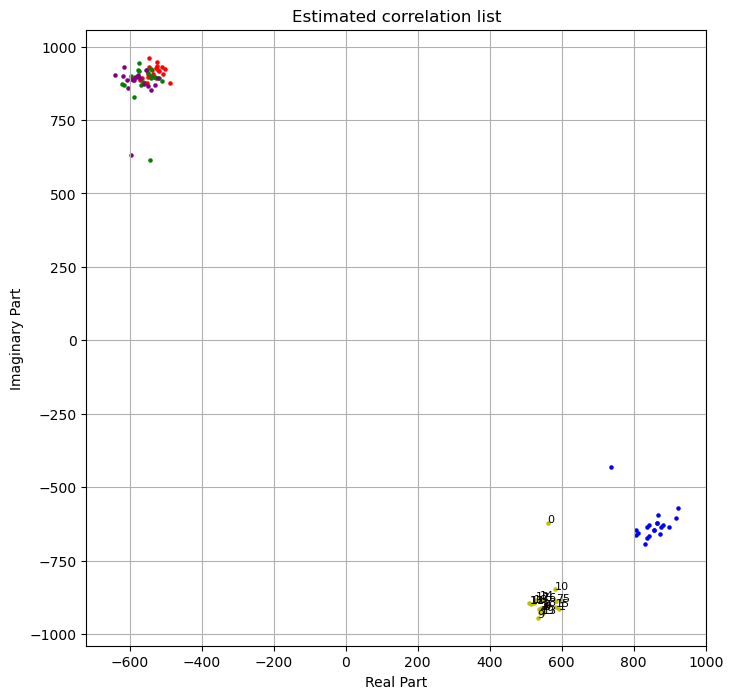

In [399]:

import cmath
# cumulative_phase = 0
new_result = []
cur_no = 0
phase_change = 0
for i in range(5):
    new = [0] * 20
    if i == 0:
        cur_no += 1
        new[0] = cor_lst[0]
        for j in range(len(cor_lst[1:20])):
            current_phase = mean_diff[i] * cur_no
            new[j+1] = cor_lst[j+1] * np.exp(1j * current_phase)
            cur_no += 1
    elif i != 0:
        if abs((degree_list[(20 * i) - 1])-(degree_list[20*i])) > 90:
            phase_change += 1
            #current_phase += np.pi * phase_change
            print("bit change")
        for j in range(20):
            current_phase = mean_diff[i] * cur_no #+ np.pi * phase_change
            new[j] = cor_lst[20 * i + j] * np.exp(1j * current_phase)
            cur_no += 1
    new_result += new
    
print(data)

plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_result[:20]), np.imag(new_result[:20]), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_result[20:40]), np.imag(new_result[20:40]), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_result[40:60]), np.imag(new_result[40:60]), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_result[60:80]), np.imag(new_result[60:80]), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_result[80:100]), np.imag(new_result[80:100]), s=5, label='New_s_5', c='purple')


for i, txt in enumerate(range(0, 20)):
    plt.annotate(f'{txt}', (np.real(new_result[i+20]), np.imag(new_result[i+20])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
#m = max(np.real(new_result[:]))
#plt.xlim(-1.1*m, 1.1*m)
#plt.ylim(-1.1*m, 1.1*m)
plt.grid(True)
plt.show()

In [400]:
for p in degree_list:
    print(p)

-80.54987138173054
-78.4013353798068
-83.05750160469597
-81.96462368096648
-79.97416798511927
-80.22325624232168
-79.62870784149473
-81.31736219314836
-81.23669556549706
-82.23434359492427
-79.23414304645922
-83.06801539819232
-81.08989028509862
-80.09804034960293
-81.1122390480773
-80.77660335431263
-84.40685649605096
-78.11688184273596
-80.24549726891384
87.39937683782847
-71.79604808759767
-78.49239169624047
-81.40659861844655
-81.55803599490879
-83.81799916261596
-77.75223196668794
-83.37027523997844
-79.6386666939582
-78.55563765360628
-86.01394610534635
-76.37398198173594
-82.09071550618667
-80.55888722139586
-82.02404010824863
-82.28392791480314
-79.93091529929856
-78.97048238739958
-81.6891309248907
-80.86357959791711
88.17343730765931
-70.48058995144497
-80.12261563234433
-82.17265645692748
-80.07904248632212
-82.63492105600042
-80.9998302383659
-84.23288000456917
-81.03911171919947
-76.27969964449298
-85.8362693805768
-76.74442450440215
-82.99519363149304
-78.4928418367326
-8

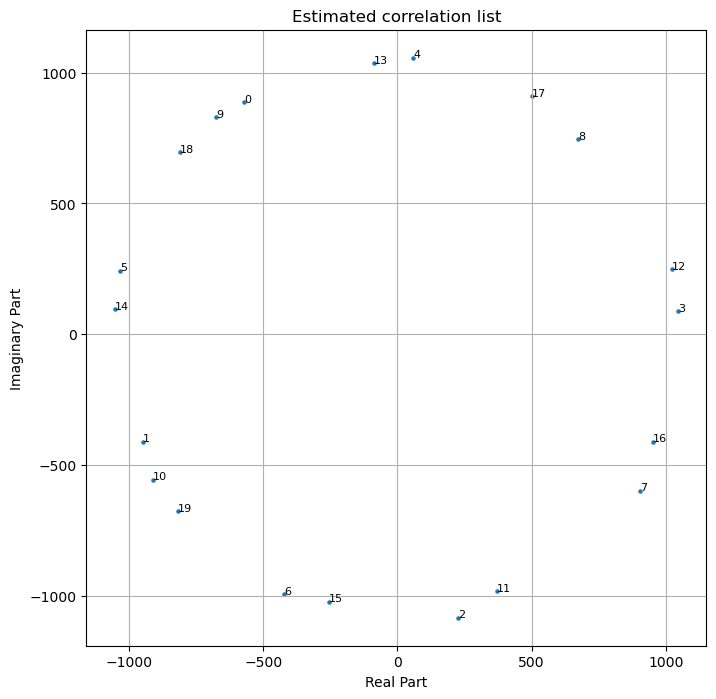

[ -571.48709175 +887.43095031j  -949.48943013 -409.51535108j
   224.82447262-1082.60053553j  1046.29949215  +87.66532835j
    59.9191011 +1056.52035736j -1031.75987011 +243.3616887j
  -422.82761683 -993.77732582j   904.1784368  -596.64520227j
   672.87400165 +744.6196181j   -675.30130193 +829.94493092j
  -909.85141278 -554.69059955j   369.29004065 -982.33955729j
  1023.84708163 +249.0327267j    -86.1787492 +1034.80706982j
 -1053.62947894  +94.80046255j  -255.10610348-1020.96441962j
   953.45105629 -409.68436836j   501.48977335 +910.48730268j
  -808.78613076 +696.37272652j  -818.96572897 -675.50488623j
  -561.57619521 +621.13048913j  -995.93162855 -441.61478838j
   227.98568506-1036.4390227j   1058.0863265   +70.50779549j
    85.83291507+1059.95802313j -1053.50798606 +201.18802028j
  -418.55202732 -983.21410604j   923.76553137 -526.67302385j
   683.82548258 +813.49705412j  -675.35440921 +848.87765758j
  -847.68096937 -583.01290136j   368.53745776 -965.44989153j
  1003.95872686 +231.4846

In [401]:
"""
print(B)
degree_list = [np.degrees(value) for value in phase_diff]
for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")
"""
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:20]), np.imag(cor_lst[:20]), s=5)

for i, txt in enumerate(range(0, 0 + 20)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()
print(cor_lst)
# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.
